<a href="https://colab.research.google.com/github/AnimeshMondol/CSE498R/blob/main/epo700.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Fri Jun 11 14:48:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"animeshmondol","key":"c4507c33debf7afb770d35a343bfcbcc"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

#Change permission
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d plameneduardo/sarscov2-ctscan-dataset

 98% 227M/230M [00:02<00:00, 75.8MB/s]
100% 230M/230M [00:02<00:00, 81.3MB/s]


In [ ]:
from zipfile import ZipFile
file_name = "sarscov2-ctscan-dataset.zip"

with ZipFile(file_name,"r") as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications.densenet import DenseNet121

In [ ]:
disease_types=['COVID', 'non-COVID']
data_dir = '/content'
train_dir = os.path.join(data_dir)

In [ ]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])
train.head()

,File,DiseaseID,Disease Type
0,COVID/Covid (63).png,0,COVID
1,COVID/Covid (386).png,0,COVID
2,COVID/Covid (816).png,0,COVID
3,COVID/Covid (896).png,0,COVID
4,COVID/Covid (782).png,0,COVID


In [ ]:
SEED = 42
train = train.sample(frac=1, random_state=SEED) 
train.index = np.arange(len(train)) # Reset indices
train.head()

,File,DiseaseID,Disease Type
0,COVID/Covid (178).png,0,COVID
1,COVID/Covid (494).png,0,COVID
2,non-COVID/Non-Covid (585).png,1,non-COVID
3,non-COVID/Non-Covid (952).png,1,non-COVID
4,COVID/Covid (710).png,0,COVID


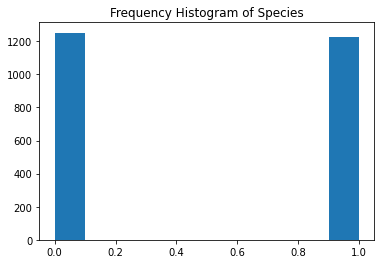

<Figure size 864x864 with 0 Axes>

In [ ]:
plt.hist(train['DiseaseID'])
plt.title('Frequency Histogram of Species')
plt.figure(figsize=(12, 12))
plt.show()

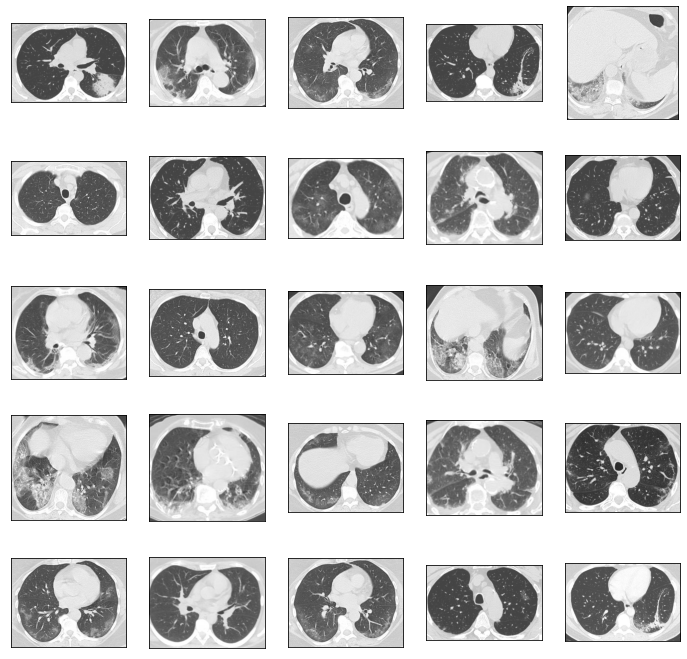

In [ ]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_defects('COVID', 5, 5)

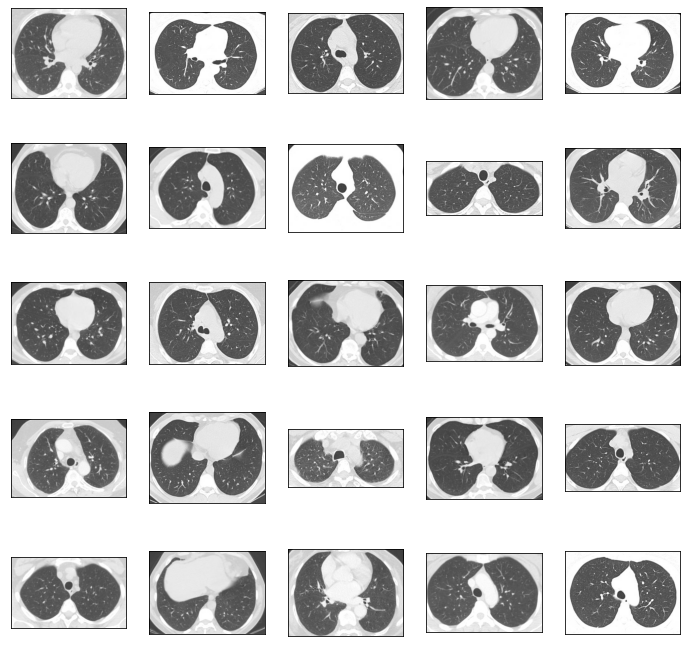

In [ ]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_defects('non-COVID', 5, 5)

In [ ]:
IMAGE_SIZE = 64
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [ ]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

2481it [00:07, 325.69it/s]


Train Shape: (2481, 64, 64, 3)


In [ ]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=2)

In [ ]:
BATCH_SIZE = 64

# Split the train and validation sets 
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)

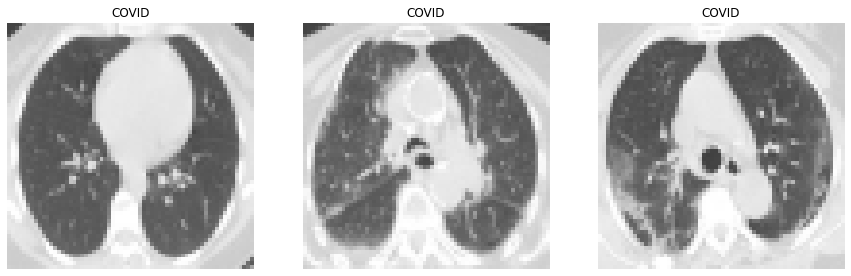

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(disease_types[np.argmax(Y_train[i])])

In [ ]:
EPOCHS = 700
SIZE=64
N_ch=3

In [ ]:
def build_densenet():
    densenet = DenseNet121(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densenet(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(2,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

In [ ]:
model = build_densenet()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically

datagen.fit(X_train)
# Fits the model on batches with real-time data augmentation
hist = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=2,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, Y_val))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 3)         84        
_________________________________________________________________
densenet121 (Functional)     (None, None, None, 1024)  7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2624

In [ ]:
final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

16/16 [==============================] - 0s 23ms/step - loss: 0.1077 - accuracy: 0.9698
Final Loss: 0.10767676681280136, Final Accuracy: 0.9698188900947571


Text(0.5, 145.31999999999996, 'Predicted')

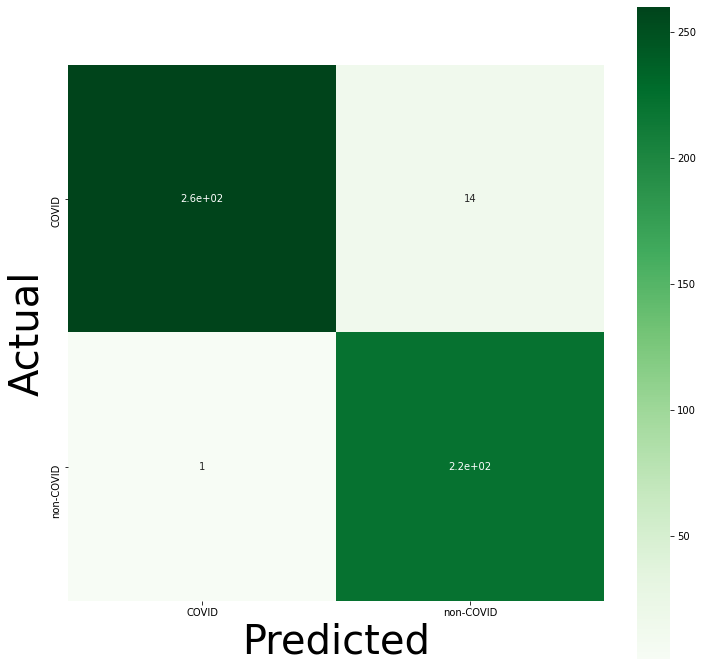

In [ ]:
Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

In [1]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

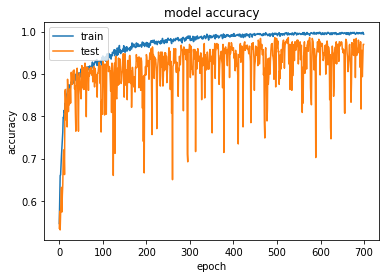

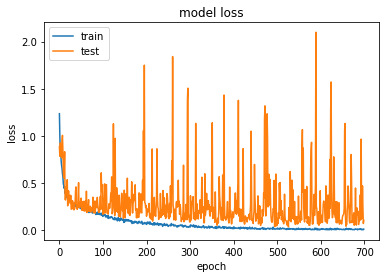

In [ ]:
# accuracy plot 
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

[9.9998713e-01 1.2861699e-05]


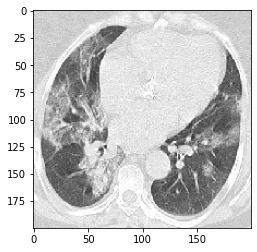

Prediction: Covid-19


In [ ]:
from skimage import io
from keras.preprocessing import image
#path='imbalanced/Scratch/Scratch_400.jpg'
img = image.load_img('/content/COVID/Covid (1010).png', grayscale=False, target_size=(64, 64))
show_img=image.load_img('/content/COVID/Covid (1010).png', grayscale=False, target_size=(200, 200))
disease_class=['Covid-19','Non Covid-19']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
        
print('Prediction:',disease_class[ind])

[7.6790944e-05 9.9992323e-01]


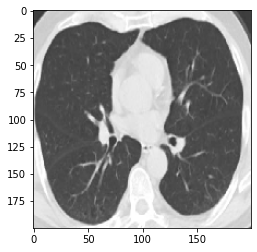

Prediction: Non Covid-19


In [ ]:
from skimage import io
from keras.preprocessing import image
#path='imbalanced/Scratch/Scratch_400.jpg'
img = image.load_img('/content/non-COVID/Non-Covid (1007).png', grayscale=False, target_size=(64, 64))
show_img=image.load_img('/content/non-COVID/Non-Covid (1007).png', grayscale=False, target_size=(200, 200))
disease_class=['Covid-19','Non Covid-19']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
        
print('Prediction:',disease_class[ind])